# Capstone Project - The Battle of Neighborhoods
### Applied Data Science Capstone
#### W. Eunkyung Gu

## Table of Contents
* Introduction: Business Problem
* Data
* Methodology
* Analysis
* Results and Discussion
* Conclusion

## Introduction: Business Problem

In this project I will try to find the best place for Koreans to live in Toronto, Canada. Specifically, this report will be targeted to stakeholders interested in **immigrating from Seoul, South Korea to Toronto**, Canada.
In order to narrow the target down and clarify the project's performance, the project will set the scope of people **migrating from Seongdong-gu, Seoul to Downtown Toronto, Toronto**.

Nowadays, there are quiet lots of Korean who try to immigrate to Canada for a variety of personal reasons, including career and academic issues. I will try to find the locations that **have similar facilities with Seoul**. I would like to find a place that meets this condition.

This project could help Koreans who want to immigrate to Canada by representing the most adaptable neighborhood in Toronto.

## Data

Based on definition of my problem, factors that will influenece our decission are:

* category and frequency of facilities in Seongdong-gu and Downtown Toronto.
* similarity of existing facilities.

Following data sources will be needed to extract/generate the required information:

* The information of Neighbourhood in Toronto, Canada including postal codes will be obtained from **Wikipedia page**. (https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M)

* The geographical coordinates of each postal code of Canada will be obtained from **a csv file**
(http://cocl.us/Geospatial_data)

* similarity of existing facilities in the neighborhood of Toronto and South Korea will be obtained using **Foursquare API**

### Neighborhood Candidates

Let's create latitude and longitude coordinates for centroids of our candidate neighborhoods. I will create a dataframe that includes info about Downtown Toronto Borough. And I will find geograpical coordiates for Seongdong-gu Borough.<br><br>
First, using Wikipedia page and csv file, I will make a Dowontown Toronto Borough dataframe.

#### Importing libraries

In [1]:
#!pip install lxml html5lib beautifulsoup4
!pip install folium
#!pip install geocoder
#!conda install -c conda-forge geopy --yes

print("Install finished!")

import pandas as pd
import numpy as np

import folium

from geopy.geocoders import Nominatim

import requests

import matplotlib.cm as cm
import matplotlib.colors as colors

from sklearn.cluster import KMeans 

import json
import requests
from pandas.io.json import json_normalize
from sklearn import preprocessing

print("Import finished!")

Install finished!
Import finished!


#### DataFrame of Downtown Toronto in Toronto, Canada
By Web scraping and importing csv.file, make a dataframe `dt`.

In [2]:
# Web scraping
url = 'https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M'
dfs = pd.read_html(url)
df = dfs[0]

# Drop the row where the Borough is 'Not assigned'
idx_1 = df[df['Borough'] == 'Not assigned'].index
df = df.drop(idx_1)
df = df.reset_index(drop=True)
df.head()

# Change the neighbourhood 'Not assigned' into the same as the borough
idx_2 = df[df['Neighbourhood'] == 'Not assigned'].index
df.iloc[idx_2, 2] = df.iloc[idx_2,1]

# importing CSV file
path = 'https://cocl.us/Geospatial_data'
df_geo = pd.read_csv(path)
df_geo.head()

# Merge the Dataframe
df_merged = df
df_merged = df.join(df_geo.set_index('Postal Code'),
                   on = 'Postal Code')

df_merged.head()

,Postal Code,Borough,Neighbourhood,Latitude,Longitude
0,M3A,North York,Parkwoods,43.753259,-79.329656
1,M4A,North York,Victoria Village,43.725882,-79.315572
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636
3,M6A,North York,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494


Make `dt` have only info for Borough "Downtown Toronto".

In [3]:
dt = df_merged[df_merged['Borough'] == 'Downtown Toronto'].reset_index(drop=True)
print(dt.shape)
dt.head()

(19, 5)


,Postal Code,Borough,Neighbourhood,Latitude,Longitude
0,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636
1,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494
2,M5B,Downtown Toronto,"Garden District, Ryerson",43.657162,-79.378937
3,M5C,Downtown Toronto,St. James Town,43.651494,-79.375418
4,M5E,Downtown Toronto,Berczy Park,43.644771,-79.373306


#### Geographical coordinate of Seongdong-gu in Seoul, South Korea

In [4]:
# latitude and longitude of Seoul
address = 'Seongdong-gu, Seoul, Republic of Korea'

geolocator = Nominatim(user_agent = "seoul_explorer")
s_location = geolocator.geocode(address)
s_latitude = s_location.latitude
s_longitude = s_location.longitude
print('The geograpical coordinate of Seongdong-gu are {}, {}'.format(s_latitude, s_longitude))

The geograpical coordinate of Seongdong-gu are 37.5635, 127.0365


### Foursquare
Now I will use Foursquare API to get info on facilities in Seoul and Toronto.

Foursquare credentials are defined in hidden cell bellow.

In [5]:
# The code was removed by Watson Studio for sharing.

#### Seongdong-gu, Seoul
First, I am going to get the top 100 venues that are in Seongdong-gu within a radius of 1000 meters.

In [6]:
radius = 1000

url = 'https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
CLIENT_ID, CLIENT_SECRET, VERSION, s_latitude, s_longitude, radius, LIMIT)

url

'https://api.foursquare.com/v2/venues/explore?client_id=VR3MWVMQV1U0RGG0S223ZPXPJC21KBF4CUFQ3FVMGUNBDSCE&client_secret=3TDSWJFLHBMYRUSM0QS3I0XYFNSROLOLJVVDR3HFGX2HYIY3&v=20180605&ll=37.5635,127.0365&radius=1000&limit=100'

In [7]:
results = requests.get(url).json()["response"]["groups"][0]['items']
results

[{'reasons': {'count': 0,
   'items': [{'summary': 'This spot is popular',
     'type': 'general',
     'reasonName': 'globalInteractionReason'}]},
  'venue': {'id': '5b6001794aa3f800335dc319',
   'name': 'INTHEMASS (인더매스)',
   'location': {'address': '성동구 마장로 270',
    'lat': 37.565261,
    'lng': 127.039908,
    'labeledLatLngs': [{'label': 'display',
      'lat': 37.565261,
      'lng': 127.039908}],
    'distance': 358,
    'postalCode': '04759',
    'cc': 'KR',
    'city': '서울특별시',
    'state': '서울특별시',
    'country': '대한민국',
    'formattedAddress': ['성동구 마장로 270',
     '마장동',
     '서울특별시',
     '서울특별시',
     '04759',
     '대한민국']},
   'categories': [{'id': '4bf58dd8d48988d1e0931735',
     'name': 'Coffee Shop',
     'pluralName': 'Coffee Shops',
     'shortName': 'Coffee Shop',
     'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/coffeeshop_',
      'suffix': '.png'},
     'primary': True}],
   'photos': {'count': 0, 'groups': []}},
  'referralId': 'e-0-5b6001794a

I will append these information into a dataframe.

In [8]:
venues_list=[]
venues_list.append([(
    v['venue']['name'],
    v['venue']['location']['lat'],
    v['venue']['location']['lng'],
    v['venue']['categories'][0]['name']) for v in results])

sd_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
sd_venues.columns = ['Venue','Venue Latitude','Venue Longitude','Venue Category']

sd_venues.head()

,Venue,Venue Latitude,Venue Longitude,Venue Category
0,INTHEMASS (인더매스),37.565261,127.039908,Coffee Shop
1,땅코참숯구이,37.560274,127.033092,BBQ Joint
2,Dome Golf (돔 골프),37.561733,127.038150,Golf Driving Range
3,CGV Wangsimni (CGV 왕십리),37.561360,127.038359,Multiplex
4,띵똥와플,37.560182,127.039472,Dessert Shop


In [9]:
sd_venues.shape

(94, 4)

In [10]:
print('There are {} uniques categories.'.format(len(sd_venues['Venue Category'].unique())))

There are 40 uniques categories.


#### Downtown Toronto, Toronto
Next, I will get facilities info for Downtown Toronto using Foursquare API. Same as above, I am going to bring top 100 venues in Downtown Toronto within a radius of 1000 meters.

In [11]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']
    

# function that makes dataframe
def getNearbyVenues(names, latitudes, longitudes, radius = 500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
    
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
        
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
        name,
        lat,
        lng,
        v['venue']['name'],
        v['venue']['location']['lat'],
        v['venue']['location']['lng'],
        v['venue']['categories'][0]['name']) for v in results])
        
    dt_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    dt_venues.columns = [
                            'Neighbourhood',
                            'Neighbourhood Latitude',
                            'Neighbourhood Longitude',
                            'Venue',
                            'Venue Latitude',
                            'Venue Longitude',
                            'Venue Category']
    
    return(dt_venues)

In [12]:
dt_venues = getNearbyVenues(names = dt['Neighbourhood'], latitudes = dt['Latitude'], longitudes = dt['Longitude'], radius = 1000)

Regent Park, Harbourfront
Queen's Park, Ontario Provincial Government
Garden District, Ryerson
St. James Town
Berczy Park
Central Bay Street
Christie
Richmond, Adelaide, King
Harbourfront East, Union Station, Toronto Islands
Toronto Dominion Centre, Design Exchange
Commerce Court, Victoria Hotel
University of Toronto, Harbord
Kensington Market, Chinatown, Grange Park
CN Tower, King and Spadina, Railway Lands, Harbourfront West, Bathurst Quay, South Niagara, Island airport
Rosedale
Stn A PO Boxes
St. James Town, Cabbagetown
First Canadian Place, Underground city
Church and Wellesley


In [13]:
print(dt_venues.shape)
dt_venues.head()

(1669, 7)


,Neighbourhood,Neighbourhood Latitude,Neighbourhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,"Regent Park, Harbourfront",43.65426,-79.360636,Roselle Desserts,43.653447,-79.362017,Bakery
1,"Regent Park, Harbourfront",43.65426,-79.360636,Tandem Coffee,43.653559,-79.361809,Coffee Shop
2,"Regent Park, Harbourfront",43.65426,-79.360636,Cooper Koo Family YMCA,43.653249,-79.358008,Distribution Center
3,"Regent Park, Harbourfront",43.65426,-79.360636,Impact Kitchen,43.656369,-79.356980,Restaurant
4,"Regent Park, Harbourfront",43.65426,-79.360636,The Distillery Historic District,43.650244,-79.359323,Historic Site


## Methodology

In this project I will direct my efforts on detecting best areas of Downtown Toronto, Toronto that have similarity of the presence and frequency of facilities to Seongdong-gu, Seoul.

In first step, I have collected the required **data: location and top 100 Venues and its Category for both borough (Dowontown Toronto, Seongdong-gu)**.

Second step in my analysis will be **clustering Neighborhoods of Downtown Toronto** using their Venue category and its frequency. I will use **K-Means clustering model** and **one-hot encoding method** for categorical variables clustering.

In third step, I will focus on categorizing the Seongdong-gu. With cluster index of Downtown Toronto, using it as categorizing index, I am going to **classify which cluster Seongdong-gu belongs to**. I will use **decision tree model** and **one-hot encoding method** for categorical variables categorizing.

## Analysis

For generating explanatory data analysis and deriving additional info, I will pick top 10 categories that appears most. Let's figure the frequency out using one-hot encoding:

#### Seongdong-gu, Seoul

In [14]:
# one hot encoding
sd_onehot = pd.get_dummies(sd_venues[['Venue Category']], prefix="", prefix_sep="")

sd_onehot = sd_onehot.mean().reset_index()
sd_onehot.columns = ['category', 'freq']
sd_onehot = sd_onehot.sort_values('freq', ascending=False).reset_index(drop=True)
sd_onehot.head(10)

,category,freq
0,Coffee Shop,0.159574
1,BBQ Joint,0.148936
2,Korean Restaurant,0.117021
3,Seafood Restaurant,0.042553
4,Café,0.042553
5,Ice Cream Shop,0.031915
6,Bakery,0.031915
7,Shopping Mall,0.021277
8,Gym / Fitness Center,0.021277
9,Fast Food Restaurant,0.021277


Change it into a more recognizable form.

In [15]:
num_top_venues = 10
indicators = ['st','nd','rd']
columns = []
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))
        
# Create a new dataframe
sd_venues_sorted = sd_onehot.T.reset_index()
sd_venues_sorted.drop('index', axis = 1, inplace=True)
sd_venues_sorted = sd_venues_sorted.iloc[:, np.arange(0,10)]

sd_venues_sorted.columns = columns
sd_venues_sorted

,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Coffee Shop,BBQ Joint,Korean Restaurant,Seafood Restaurant,Café,Ice Cream Shop,Bakery,Shopping Mall,Gym / Fitness Center,Fast Food Restaurant
1,0.159574,0.148936,0.117021,0.0425532,0.0425532,0.0319149,0.0319149,0.0212766,0.0212766,0.0212766


We successfully extract top 10 Common Venues Categories and their frequency of Seongdong-gu.
1. Coffee Shop: 0.16
2. Hotel: 0.09
3. Korean Restaurant: 0.07
4. Chinese Restaurant: 0.05
5. Lounge: 0.04
6. Bookstore: 0.04
7. Japanese Restaurant: 0.04
8. Cafe: 0.04
9. Historic Site: 0.03
10. Plaza: 0.03

#### Toronto
Now, we are going same analysis to get top 10 Common Venues of each Neighborhood in Toronto.

In [16]:
dt_venues.head()

,Neighbourhood,Neighbourhood Latitude,Neighbourhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,"Regent Park, Harbourfront",43.65426,-79.360636,Roselle Desserts,43.653447,-79.362017,Bakery
1,"Regent Park, Harbourfront",43.65426,-79.360636,Tandem Coffee,43.653559,-79.361809,Coffee Shop
2,"Regent Park, Harbourfront",43.65426,-79.360636,Cooper Koo Family YMCA,43.653249,-79.358008,Distribution Center
3,"Regent Park, Harbourfront",43.65426,-79.360636,Impact Kitchen,43.656369,-79.356980,Restaurant
4,"Regent Park, Harbourfront",43.65426,-79.360636,The Distillery Historic District,43.650244,-79.359323,Historic Site


In [17]:
dt_venues.groupby('Neighbourhood').count()

,Neighbourhood Latitude,Neighbourhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighbourhood,,,,,,
Berczy Park,100,100,100,100,100,100
"CN Tower, King and Spadina, Railway Lands, Harbourfront West, Bathurst Quay, South Niagara, Island airport",14,14,14,14,14,14
Central Bay Street,100,100,100,100,100,100
Christie,100,100,100,100,100,100
Church and Wellesley,100,100,100,100,100,100
"Commerce Court, Victoria Hotel",100,100,100,100,100,100
"First Canadian Place, Underground city",100,100,100,100,100,100
"Garden District, Ryerson",100,100,100,100,100,100
"Harbourfront East, Union Station, Toronto Islands",100,100,100,100,100,100


In [18]:
print('There are {} unique categories.'.format(len(dt_venues['Venue Category'].unique())))

There are 201 unique categories.


Analyze Each Neighbourhood

In [19]:
dt_temp = pd.get_dummies(dt_venues[['Venue Category']],prefix = '', prefix_sep='')

dt_temp['Neighbourhood'] = dt_venues['Neighbourhood']

fixed_columns = [dt_temp.columns[-1]]+list(dt_temp.columns[:-1])
dt_temp = dt_temp[fixed_columns]

dt_temp.head()

,Neighbourhood,Airport,American Restaurant,Animal Shelter,Aquarium,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,...,Theme Restaurant,Track,Train Station,Udon Restaurant,University,Vegetarian / Vegan Restaurant,Video Store,Vietnamese Restaurant,Wine Bar,Yoga Studio
0,"Regent Park, Harbourfront",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,"Regent Park, Harbourfront",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,"Regent Park, Harbourfront",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,"Regent Park, Harbourfront",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,"Regent Park, Harbourfront",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [20]:
dt_temp.shape

(1669, 202)

In [21]:
dt_onehot = dt_temp.groupby('Neighbourhood').mean().reset_index()
dt_onehot

,Neighbourhood,Airport,American Restaurant,Animal Shelter,Aquarium,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,...,Theme Restaurant,Track,Train Station,Udon Restaurant,University,Vegetarian / Vegan Restaurant,Video Store,Vietnamese Restaurant,Wine Bar,Yoga Studio
0,Berczy Park,0.000000,0.010000,0.00,0.00,0.01,0.00,0.00,0.00,0.000000,...,0.00,0.000000,0.01,0.00,0.00,0.01,0.00,0.00,0.00,0.00
1,"CN Tower, King and Spadina, Railway Lands, Har...",0.071429,0.000000,0.00,0.00,0.00,0.00,0.00,0.00,0.000000,...,0.00,0.071429,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2,Central Bay Street,0.000000,0.010000,0.00,0.00,0.02,0.01,0.01,0.00,0.000000,...,0.00,0.000000,0.00,0.00,0.01,0.02,0.00,0.00,0.01,0.02
3,Christie,0.000000,0.010000,0.00,0.00,0.01,0.00,0.00,0.00,0.000000,...,0.00,0.000000,0.00,0.00,0.00,0.02,0.00,0.01,0.01,0.00
4,Church and Wellesley,0.000000,0.010000,0.00,0.00,0.01,0.00,0.00,0.00,0.000000,...,0.01,0.000000,0.00,0.00,0.00,0.00,0.00,0.01,0.00,0.02
5,"Commerce Court, Victoria Hotel",0.000000,0.020000,0.00,0.00,0.02,0.00,0.00,0.01,0.000000,...,0.00,0.000000,0.01,0.00,0.00,0.02,0.00,0.00,0.00,0.00
6,"First Canadian Place, Underground city",0.000000,0.020000,0.00,0.00,0.01,0.00,0.00,0.01,0.000000,...,0.00,0.000000,0.01,0.00,0.00,0.02,0.00,0.00,0.00,0.00
7,"Garden District, Ryerson",0.000000,0.010000,0.00,0.00,0.00,0.01,0.00,0.00,0.000000,...,0.00,0.000000,0.00,0.00,0.00,0.00,0.00,0.00,0.01,0.01
8,"Harbourfront East, Union Station, Toronto Islands",0.000000,0.000000,0.00,0.02,0.01,0.00,0.00,0.01,0.000000,...,0.00,0.010000,0.01,0.00,0.00,0.02,0.00,0.00,0.00,0.01
9,"Kensington Market, Chinatown, Grange Park",0.000000,0.000000,0.00,0.00,0.03,0.00,0.01,0.00,0.000000,...,0.00,0.000000,0.00,0.01,0.01,0.05,0.00,0.02,0.01,0.03


In [22]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending = False)
    return row_categories_sorted.index.values[0:num_top_venues]

In [23]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

columns = ['Neighbourhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))
        
dt_venues_sorted = pd.DataFrame(columns = columns)
dt_venues_sorted['Neighbourhood'] = dt_onehot['Neighbourhood']

for ind in np.arange(dt_onehot.shape[0]):
    dt_venues_sorted.iloc[ind, 1:] = return_most_common_venues(dt_onehot.iloc[ind, :], num_top_venues)
    
dt_venues_sorted

,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Berczy Park,Coffee Shop,Café,Japanese Restaurant,Hotel,Beer Bar,Park,Restaurant,Gastropub,Liquor Store,Grocery Store
1,"CN Tower, King and Spadina, Railway Lands, Har...",Coffee Shop,Harbor / Marina,Café,Airport,Garden,Park,Dog Run,Scenic Lookout,Sculpture Garden,Dance Studio
2,Central Bay Street,Coffee Shop,Sushi Restaurant,Café,Japanese Restaurant,Ramen Restaurant,Park,Cosmetics Shop,Breakfast Spot,Bubble Tea Shop,Plaza
3,Christie,Korean Restaurant,Café,Coffee Shop,Grocery Store,Cocktail Bar,Mexican Restaurant,Ice Cream Shop,Bar,Park,Comedy Club
4,Church and Wellesley,Coffee Shop,Japanese Restaurant,Gay Bar,Park,Men's Store,Sushi Restaurant,Hotel,Ramen Restaurant,Pizza Place,Yoga Studio
5,"Commerce Court, Victoria Hotel",Coffee Shop,Hotel,Café,Restaurant,Japanese Restaurant,Gastropub,Beer Bar,Concert Hall,Seafood Restaurant,Vegetarian / Vegan Restaurant
6,"First Canadian Place, Underground city",Coffee Shop,Hotel,Café,Restaurant,Japanese Restaurant,Gastropub,Theater,Concert Hall,Beer Bar,Italian Restaurant
7,"Garden District, Ryerson",Coffee Shop,Japanese Restaurant,Gastropub,Italian Restaurant,Restaurant,Diner,New American Restaurant,Creperie,Middle Eastern Restaurant,Cosmetics Shop
8,"Harbourfront East, Union Station, Toronto Islands",Coffee Shop,Café,Hotel,Restaurant,Park,Theater,Brewery,Gym,Scenic Lookout,Japanese Restaurant
9,"Kensington Market, Chinatown, Grange Park",Café,Bar,Vegetarian / Vegan Restaurant,Coffee Shop,Mexican Restaurant,Yoga Studio,Art Gallery,Park,Bakery,Beer Bar


I have listed the 10 most common venues for the neighbourhood of downtown toronto.
Also, onehot encoding dataframe for both Seongdong-gu and Downtown Toronto is ready.

### Cluster Neighbourhoods in Downtown Toronto
Let's cluster the neighbourhoods in Downtown Toronto. Variables for cluster are 10 most common venue categories. These are categorical values, so I have to use onehot encoding dataframe to cluster.

I will use K-Means Clustering model, and the number of clusters will be 5.

In [24]:
# number of clusters
kclusters = 5

dt_onehot_clustering = dt_onehot.drop('Neighbourhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters = kclusters, random_state = 0).fit(dt_onehot_clustering)

kmeans.labels_

array([4, 2, 3, 1, 3, 4, 4, 3, 4, 1, 3, 3, 4, 0, 4, 3, 4, 4, 1],
      dtype=int32)

In [25]:
# add clustering labels
dt_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)
print(dt_venues_sorted.shape)
dt_venues_sorted.head()

(19, 12)


,Cluster Labels,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,4,Berczy Park,Coffee Shop,Café,Japanese Restaurant,Hotel,Beer Bar,Park,Restaurant,Gastropub,Liquor Store,Grocery Store
1,2,"CN Tower, King and Spadina, Railway Lands, Har...",Coffee Shop,Harbor / Marina,Café,Airport,Garden,Park,Dog Run,Scenic Lookout,Sculpture Garden,Dance Studio
2,3,Central Bay Street,Coffee Shop,Sushi Restaurant,Café,Japanese Restaurant,Ramen Restaurant,Park,Cosmetics Shop,Breakfast Spot,Bubble Tea Shop,Plaza
3,1,Christie,Korean Restaurant,Café,Coffee Shop,Grocery Store,Cocktail Bar,Mexican Restaurant,Ice Cream Shop,Bar,Park,Comedy Club
4,3,Church and Wellesley,Coffee Shop,Japanese Restaurant,Gay Bar,Park,Men's Store,Sushi Restaurant,Hotel,Ramen Restaurant,Pizza Place,Yoga Studio


Let's make it look good.

In [26]:
dt_clustered = dt

dt_clustered = dt_clustered.join(dt_venues_sorted.set_index('Neighbourhood'),
                           on = 'Neighbourhood')
dt_clustered.dropna(inplace = True)
dt_clustered['Cluster Labels'] = dt_clustered['Cluster Labels'].astype(int)
print(dt_clustered.shape)
dt_clustered.head()

(19, 16)


,Postal Code,Borough,Neighbourhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636,3,Coffee Shop,Pub,Café,Park,Theater,Restaurant,Breakfast Spot,Diner,Bakery,Indian Restaurant
1,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494,3,Coffee Shop,Park,Japanese Restaurant,Italian Restaurant,Café,Sushi Restaurant,Dance Studio,Ramen Restaurant,Restaurant,Middle Eastern Restaurant
2,M5B,Downtown Toronto,"Garden District, Ryerson",43.657162,-79.378937,3,Coffee Shop,Japanese Restaurant,Gastropub,Italian Restaurant,Restaurant,Diner,New American Restaurant,Creperie,Middle Eastern Restaurant,Cosmetics Shop
3,M5C,Downtown Toronto,St. James Town,43.651494,-79.375418,4,Coffee Shop,Café,Restaurant,Gastropub,Beer Bar,Seafood Restaurant,Italian Restaurant,Bakery,Hotel,Gym
4,M5E,Downtown Toronto,Berczy Park,43.644771,-79.373306,4,Coffee Shop,Café,Japanese Restaurant,Hotel,Beer Bar,Park,Restaurant,Gastropub,Liquor Store,Grocery Store


Let's show this information on the map using folium.

In [27]:
# create map
t_address = 'Downtown Toronto, Toronto, Canada'

t_geolocator = Nominatim(user_agent = 'toronto_explorer')
t_location = geolocator.geocode(t_address)
t_latitude = t_location.latitude
t_longitude = t_location.longitude

map_clusters = folium.Map(location=[t_latitude, t_longitude], zoom_start=12)

# set color scheme for the clusters
x = np.arange(kclusters) # kclusters = 10
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(dt_clustered['Latitude'], dt_clustered['Longitude'], dt_clustered['Neighbourhood'], dt_clustered['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

### Classify which cluster Seongdong-gu belongs to.

Using decision Trees model, let's classify which cluster Seongdong-gu belongs to among cluster 1-6. I will use onehot encoding dataframe for classification. Decision Tree classifier criterio will be 'entropy'.

Before starting classification, I should some process my data a bit.

In [28]:
sd_onehot_p = sd_onehot.T
sd_onehot_p.rename(columns = sd_onehot_p.iloc[0,:],inplace = True)
sd_onehot_p = sd_onehot_p.drop([sd_onehot_p.index[0]])
sd_onehot_p

,Coffee Shop,BBQ Joint,Korean Restaurant,Seafood Restaurant,Café,Ice Cream Shop,Bakery,Shopping Mall,Gym / Fitness Center,Fast Food Restaurant,...,History Museum,Golf Driving Range,Fried Chicken Joint,Electronics Store,Dumpling Restaurant,Dessert Shop,Dance Studio,Burger Joint,Bubble Tea Shop,Vietnamese Restaurant
freq,0.159574,0.148936,0.117021,0.0425532,0.0425532,0.0319149,0.0319149,0.0212766,0.0212766,0.0212766,...,0.0106383,0.0106383,0.0106383,0.0106383,0.0106383,0.0106383,0.0106383,0.0106383,0.0106383,0.0106383


In [29]:
dt_onehot_p = pd.DataFrame({'Cluster Labels': kmeans.labels_})
dt_onehot_p = pd.concat([dt_onehot_p, dt_onehot], axis = 1)
print(dt_onehot_p.shape)
dt_onehot_p

(19, 203)


,Cluster Labels,Neighbourhood,Airport,American Restaurant,Animal Shelter,Aquarium,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,...,Theme Restaurant,Track,Train Station,Udon Restaurant,University,Vegetarian / Vegan Restaurant,Video Store,Vietnamese Restaurant,Wine Bar,Yoga Studio
0,4,Berczy Park,0.000000,0.010000,0.00,0.00,0.01,0.00,0.00,0.00,...,0.00,0.000000,0.01,0.00,0.00,0.01,0.00,0.00,0.00,0.00
1,2,"CN Tower, King and Spadina, Railway Lands, Har...",0.071429,0.000000,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.071429,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2,3,Central Bay Street,0.000000,0.010000,0.00,0.00,0.02,0.01,0.01,0.00,...,0.00,0.000000,0.00,0.00,0.01,0.02,0.00,0.00,0.01,0.02
3,1,Christie,0.000000,0.010000,0.00,0.00,0.01,0.00,0.00,0.00,...,0.00,0.000000,0.00,0.00,0.00,0.02,0.00,0.01,0.01,0.00
4,3,Church and Wellesley,0.000000,0.010000,0.00,0.00,0.01,0.00,0.00,0.00,...,0.01,0.000000,0.00,0.00,0.00,0.00,0.00,0.01,0.00,0.02
5,4,"Commerce Court, Victoria Hotel",0.000000,0.020000,0.00,0.00,0.02,0.00,0.00,0.01,...,0.00,0.000000,0.01,0.00,0.00,0.02,0.00,0.00,0.00,0.00
6,4,"First Canadian Place, Underground city",0.000000,0.020000,0.00,0.00,0.01,0.00,0.00,0.01,...,0.00,0.000000,0.01,0.00,0.00,0.02,0.00,0.00,0.00,0.00
7,3,"Garden District, Ryerson",0.000000,0.010000,0.00,0.00,0.00,0.01,0.00,0.00,...,0.00,0.000000,0.00,0.00,0.00,0.00,0.00,0.00,0.01,0.01
8,4,"Harbourfront East, Union Station, Toronto Islands",0.000000,0.000000,0.00,0.02,0.01,0.00,0.00,0.01,...,0.00,0.010000,0.01,0.00,0.00,0.02,0.00,0.00,0.00,0.01
9,1,"Kensington Market, Chinatown, Grange Park",0.000000,0.000000,0.00,0.00,0.03,0.00,0.01,0.00,...,0.00,0.000000,0.00,0.01,0.01,0.05,0.00,0.02,0.01,0.03


In [30]:
dt_onehot_p.columns[2:]

Index(['Airport', 'American Restaurant', 'Animal Shelter', 'Aquarium',
       'Art Gallery', 'Art Museum', 'Arts & Crafts Store', 'Asian Restaurant',
       'Athletics & Sports', 'Auto Dealership',
       ...
       'Theme Restaurant', 'Track', 'Train Station', 'Udon Restaurant',
       'University', 'Vegetarian / Vegan Restaurant', 'Video Store',
       'Vietnamese Restaurant', 'Wine Bar', 'Yoga Studio'],
      dtype='object', length=201)

In [31]:
for name in sd_onehot_p.columns:
    if name in dt_onehot_p.columns:
        None
    else:
        dt_onehot_p[name] = 0
print(dt_onehot_p.shape)
dt_onehot_p.head()

(19, 214)


,Cluster Labels,Neighbourhood,Airport,American Restaurant,Animal Shelter,Aquarium,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,...,Buffet,Korean BBQ Restaurant,Toy / Game Store,Multiplex,Arcade,Janguh Restaurant,Intersection,Indoor Play Area,History Museum,Golf Driving Range
0,4,Berczy Park,0.000000,0.01,0.0,0.0,0.01,0.00,0.00,0.0,...,0,0,0,0,0,0,0,0,0,0
1,2,"CN Tower, King and Spadina, Railway Lands, Har...",0.071429,0.00,0.0,0.0,0.00,0.00,0.00,0.0,...,0,0,0,0,0,0,0,0,0,0
2,3,Central Bay Street,0.000000,0.01,0.0,0.0,0.02,0.01,0.01,0.0,...,0,0,0,0,0,0,0,0,0,0
3,1,Christie,0.000000,0.01,0.0,0.0,0.01,0.00,0.00,0.0,...,0,0,0,0,0,0,0,0,0,0
4,3,Church and Wellesley,0.000000,0.01,0.0,0.0,0.01,0.00,0.00,0.0,...,0,0,0,0,0,0,0,0,0,0


Processing finished. For classification, I will split the data into trainset and testset.

In [32]:
dt_X = dt_onehot_p[dt_onehot_p.columns[2:]].values
print(dt_X[0:5])
dt_y = dt_onehot_p['Cluster Labels']
print(dt_y[0:5])

[[0.         0.01       0.         ... 0.         0.         0.        ]
 [0.07142857 0.         0.         ... 0.         0.         0.        ]
 [0.         0.01       0.         ... 0.         0.         0.        ]
 [0.         0.01       0.         ... 0.         0.         0.        ]
 [0.         0.01       0.         ... 0.         0.         0.        ]]
0    4
1    2
2    3
3    1
4    3
Name: Cluster Labels, dtype: int32


In [33]:
from sklearn.model_selection import train_test_split

X_trainset, X_testset, y_trainset, y_testset = train_test_split(dt_X, dt_y, test_size=0.15, random_state=3)

print("Shape of X_trainset: ", X_trainset.shape)
print("Shape of y_trainset: ", y_trainset.shape)
print("Shape of X_testset: ", X_testset.shape)
print("Shape of y_testset: ", y_testset.shape)

Shape of X_trainset:  (16, 212)
Shape of y_trainset:  (16,)
Shape of X_testset:  (3, 212)
Shape of y_testset:  (3,)


In [34]:
from sklearn.tree import DecisionTreeClassifier

cTree = DecisionTreeClassifier(criterion="entropy", max_depth = 4)
cTree

DecisionTreeClassifier(criterion='entropy', max_depth=4)

In [35]:
# Train the model

cTree.fit(X_trainset, y_trainset)

DecisionTreeClassifier(criterion='entropy', max_depth=4)

In [36]:
# Predict using the model

predTree_test = cTree.predict(X_testset)
print(predTree_test)
print(y_testset)

[4 3 1]
12    4
2     3
1     2
Name: Cluster Labels, dtype: int32


Let's evaluate the accuracy of decision tree model.

In [37]:
from sklearn import metrics
import matplotlib.pyplot as plt
print("DecisionTree's Accuracy: ", metrics.accuracy_score(y_testset, predTree_test))

DecisionTree's Accuracy:  0.6666666666666666


Models' accuracy is about 0.67. From now on, I will classify Seongdong-gu.

In [38]:
sd_X = sd_onehot_p

for name in dt_onehot_p.columns[2:]:
    if name in sd_X.columns:
        None
    else:
        sd_X[name] = 0
sd_X

,Coffee Shop,BBQ Joint,Korean Restaurant,Seafood Restaurant,Café,Ice Cream Shop,Bakery,Shopping Mall,Gym / Fitness Center,Fast Food Restaurant,...,Thai Restaurant,Theater,Theme Restaurant,Track,Train Station,University,Vegetarian / Vegan Restaurant,Video Store,Wine Bar,Yoga Studio
freq,0.159574,0.148936,0.117021,0.0425532,0.0425532,0.0319149,0.0319149,0.0212766,0.0212766,0.0212766,...,0,0,0,0,0,0,0,0,0,0


In [39]:
predTree_sd = cTree.predict(sd_X)

In [50]:
print(predTree_sd)
print("Seongdong-gu belongs to cluster {}.".format(predTree_sd[0]+1))

[1]
Seongdong-gu belongs to cluster 2.


This concludes analysis.

In [49]:
print(dt_clustered[dt_clustered['Cluster Labels'] == 1]['Neighbourhood'].values)
dt_clustered[dt_clustered['Cluster Labels'] == 1]

['Christie' 'University of Toronto, Harbord'
 'Kensington Market, Chinatown, Grange Park']


,Postal Code,Borough,Neighbourhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
6,M6G,Downtown Toronto,Christie,43.669542,-79.422564,1,Korean Restaurant,Café,Coffee Shop,Grocery Store,Cocktail Bar,Mexican Restaurant,Ice Cream Shop,Bar,Park,Comedy Club
11,M5S,Downtown Toronto,"University of Toronto, Harbord",43.662696,-79.400049,1,Café,Bakery,Vegetarian / Vegan Restaurant,Coffee Shop,Bar,Beer Bar,Bookstore,Restaurant,Mexican Restaurant,Ice Cream Shop
12,M5T,Downtown Toronto,"Kensington Market, Chinatown, Grange Park",43.653206,-79.400049,1,Café,Bar,Vegetarian / Vegan Restaurant,Coffee Shop,Mexican Restaurant,Yoga Studio,Art Gallery,Park,Bakery,Beer Bar


#### Visualization

In [42]:
!conda install pydotplus
#!conda install -c conda-forge python-graphviz -y
#!pip install six
print('Install finished')

Solving environment: done
^C

CondaError: KeyboardInterrupt

Install finished


In [43]:
from six import StringIO
import pydotplus
import matplotlib.image as mpimg
from sklearn import tree
%matplotlib inline

In [44]:
dt_onehot_p.head()

,Cluster Labels,Neighbourhood,Airport,American Restaurant,Animal Shelter,Aquarium,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,...,Buffet,Korean BBQ Restaurant,Toy / Game Store,Multiplex,Arcade,Janguh Restaurant,Intersection,Indoor Play Area,History Museum,Golf Driving Range
0,4,Berczy Park,0.000000,0.01,0.0,0.0,0.01,0.00,0.00,0.0,...,0,0,0,0,0,0,0,0,0,0
1,2,"CN Tower, King and Spadina, Railway Lands, Har...",0.071429,0.00,0.0,0.0,0.00,0.00,0.00,0.0,...,0,0,0,0,0,0,0,0,0,0
2,3,Central Bay Street,0.000000,0.01,0.0,0.0,0.02,0.01,0.01,0.0,...,0,0,0,0,0,0,0,0,0,0
3,1,Christie,0.000000,0.01,0.0,0.0,0.01,0.00,0.00,0.0,...,0,0,0,0,0,0,0,0,0,0
4,3,Church and Wellesley,0.000000,0.01,0.0,0.0,0.01,0.00,0.00,0.0,...,0,0,0,0,0,0,0,0,0,0


In [45]:
sd_onehot_p.head()

,Coffee Shop,BBQ Joint,Korean Restaurant,Seafood Restaurant,Café,Ice Cream Shop,Bakery,Shopping Mall,Gym / Fitness Center,Fast Food Restaurant,...,Thai Restaurant,Theater,Theme Restaurant,Track,Train Station,University,Vegetarian / Vegan Restaurant,Video Store,Wine Bar,Yoga Studio
freq,0.159574,0.148936,0.117021,0.0425532,0.0425532,0.0319149,0.0319149,0.0212766,0.0212766,0.0212766,...,0,0,0,0,0,0,0,0,0,0


In [46]:
dt_onehot_p[dt_onehot_p["Cluster Labels"] == 0]

,Cluster Labels,Neighbourhood,Airport,American Restaurant,Animal Shelter,Aquarium,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,...,Buffet,Korean BBQ Restaurant,Toy / Game Store,Multiplex,Arcade,Janguh Restaurant,Intersection,Indoor Play Area,History Museum,Golf Driving Range
13,0,Rosedale,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0


Let's Visualization the Decision tree.

In [47]:
y_trainset.unique()

array([4, 3, 1, 0], dtype=int32)

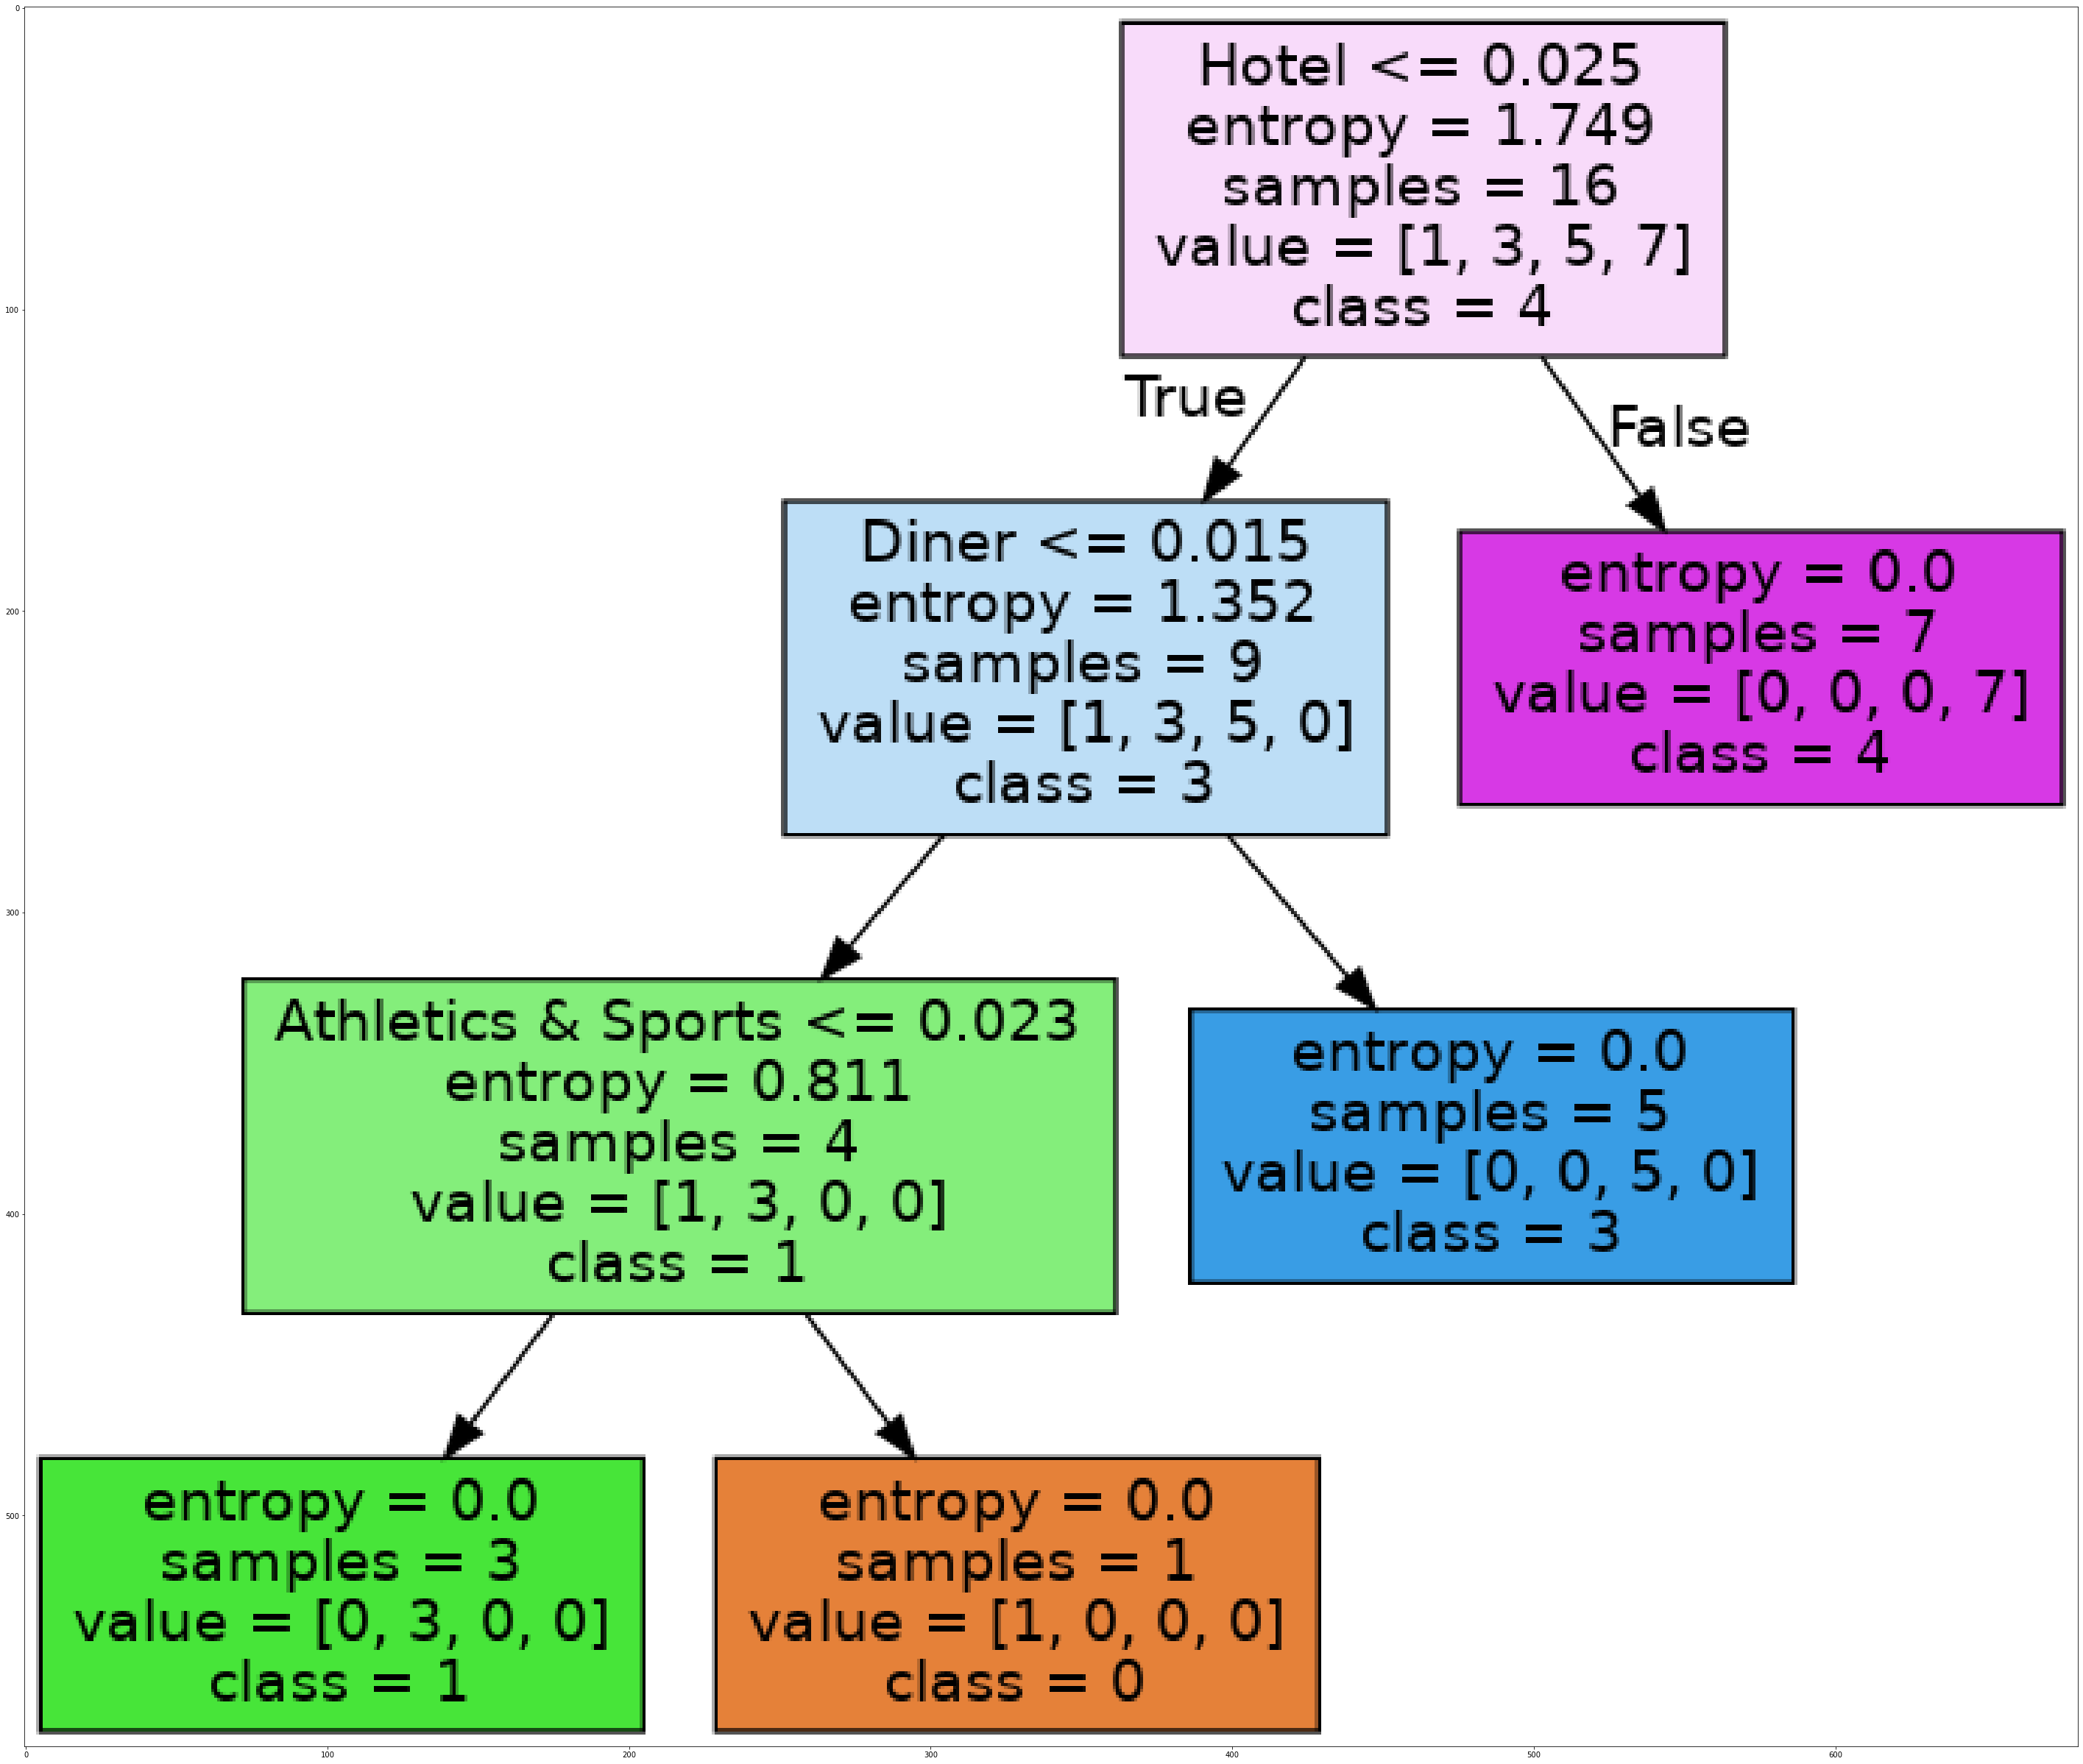

In [48]:
dot_data = StringIO()
filename = "clustertree.png"
featureNames = dt_onehot_p.columns[2:]
targetNames = str(dt_onehot_p["Cluster Labels"].unique())

out=tree.export_graphviz(cTree,feature_names=featureNames, out_file=dot_data, class_names= ['0','1','3','4'], filled=True)  
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
graph.write_png(filename)
img = mpimg.imread(filename)
plt.figure(figsize=(50,100))
plt.imshow(img,interpolation='nearest')

## Results and Discussion

Analysis shows that Seongdong-gu was predicted to belong to cluster 1. Cluster 1 includes the neighbourhoods such as:
* Christie
* University of Toronto, Harbord
* Kensington Market, Chinatown, Grange Park

In other workds, there is a similarity of facilities between in Seongdong-gu and these areas. From this point on, Koreans from Seongdong-gu will be able to adapt quickly and well when they move to these area mentioned above.

However, the project following limitations:
* The number of data used for clustering and classification was 19. And this was not enough (actually, lack) to train. The accuracy of Decision tree in this project showed quiet low at 0.67. There is room for further improving the model by increasing the amount of data.
* Clustering and classfication index were created simply in proportion to the number of facilities. In other words, it is calculated without proper consideratino of the overall ratio, which may give ambiguity to analysis. For example coffee shops or restaurants are a lot in any area, and historical sites are a few in any area, But this project did not take that into account.

## Conclusion

Purpose of this project was to reveal which neighbourhood in Downtown Toronto is most similar to Sengdong-gu, in order to aid stakeholders the search for optimal location for the best immigration destination. Based on data from Foursquare API, I clustered and classified the areas. And it showed calculated best place.

The final decision on choosing the optial location will be made by stakeholders based on the characteristics(included in this project or not) of the region. This project will be a good reference for them.